<a href="https://colab.research.google.com/github/ChitviJoshi/Post_Recommendation_System/blob/main/Post_Recommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Author**:
*  Chitvi Joshi
*  30/09/25

In [121]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import NearestNeighbors
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

## DATA LOADING

In [122]:
users_df = pd.read_csv('Users.csv')
posts_df = pd.read_csv('Posts.csv')
engagements_df = pd.read_csv('Engagements.csv')

print(f"Stats: {len(users_df)} users, {len(posts_df)} posts, {len(engagements_df)} engagements")

Stats: 50 users, 100 posts, 1000 engagements


## EDA

EDA
   Engagement rate: 49.7%
   Avg user age: 26


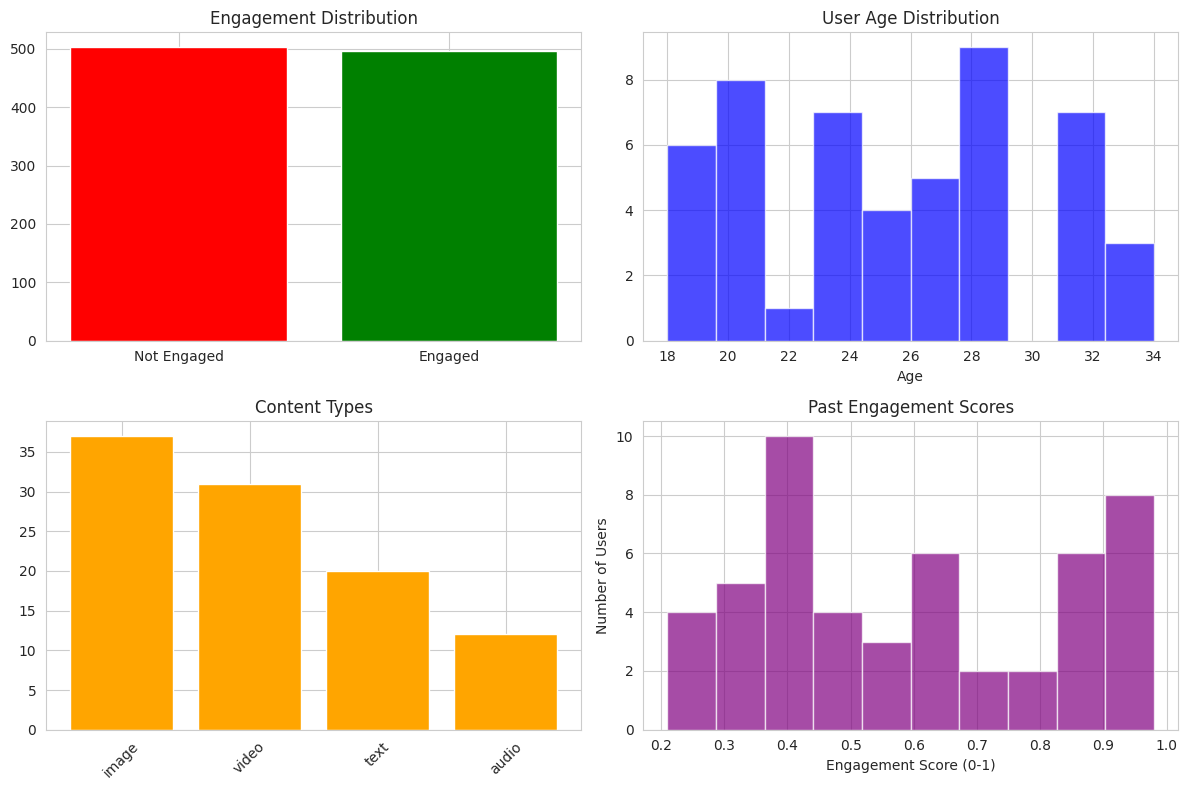

In [123]:
users_df['interests_list'] = users_df['top_3_interests'].str.lower().str.split(', ')
posts_df['tags_list'] = posts_df['tags'].str.lower().str.split(', ')

print("EDA")
print(f"   Engagement rate: {engagements_df['engagement'].mean():.1%}")
print(f"   Avg user age: {users_df['age'].mean():.0f}")

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Plt 1: user engagement
eng_counts = engagements_df['engagement'].value_counts()
axes[0, 0].bar(['Not Engaged', 'Engaged'], eng_counts.values, color=['red', 'green'])
axes[0, 0].set_title('Engagement Distribution')

# Plt 2: User age distr
axes[0, 1].hist(users_df['age'], bins=10, color='blue', alpha=0.7)
axes[0, 1].set_title('User Age Distribution')
axes[0, 1].set_xlabel('Age')

# Plt 3: Content types
content_types = posts_df['content_type'].value_counts()
axes[1, 0].bar(content_types.index, content_types.values, color='orange')
axes[1, 0].set_title('Content Types')
axes[1, 0].tick_params(axis='x', rotation=45)

# Plt 4: Past engagement
axes[1, 1].hist(users_df['past_engagement_score'], bins=10, color='purple', alpha=0.7)
axes[1, 1].set_title('Past Engagement Scores')
axes[1, 1].set_xlabel('Engagement Score (0-1)')
axes[1, 1].set_ylabel('Number of Users')

plt.tight_layout()
plt.savefig('EDA.png', dpi=200)
plt.show()
plt.close()

## Interest Coherence Graph

Interest Coherence Graph


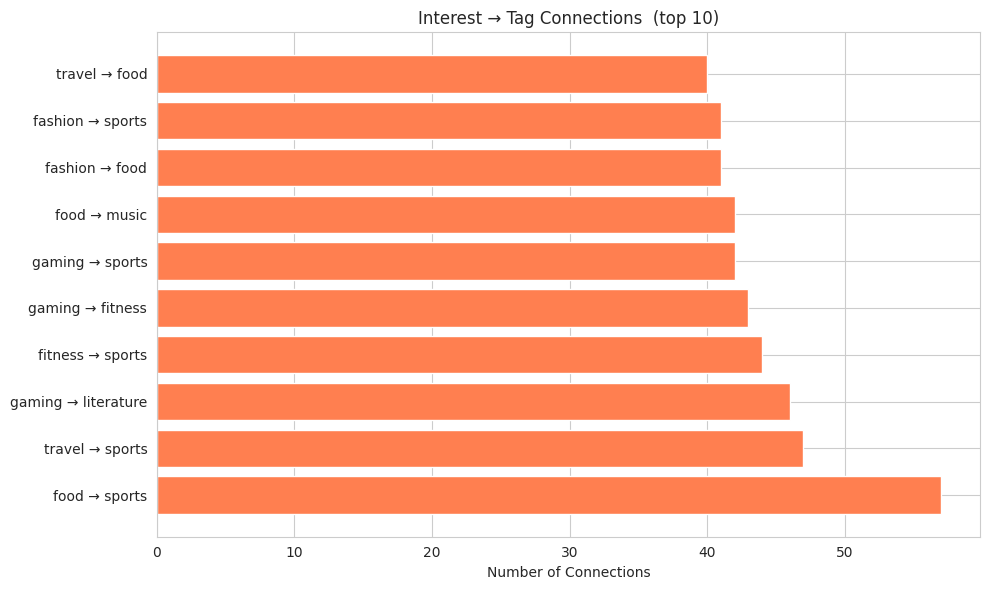

In [124]:
interest_graph = {}

for _, eng in engagements_df.iterrows():
    if eng['engagement'] == 0:
        continue

    user = users_df[users_df['user_id'] == eng['user_id']].iloc[0]
    post = posts_df[posts_df['post_id'] == eng['post_id']].iloc[0]

    for interest in user['interests_list']:
        if interest not in interest_graph:
            interest_graph[interest] = {}

        for tag in post['tags_list']:
            if tag not in interest_graph[interest]:
                interest_graph[interest][tag] = 0
            interest_graph[interest][tag] += 1

plt.figure(figsize=(10, 6))

all_connections = []
for interest in interest_graph:
    for tag, count in interest_graph[interest].items():
        if interest != tag:  #avoids repeating words
            all_connections.append((interest, tag, count))

ex_top_10 = sorted(all_connections, key=lambda x: x[2], reverse=True)[:10]

labels = [f"{i} → {t}" for i, t, c in ex_top_10]
counts = [c for i, t, c in ex_top_10]

print("Interest Coherence Graph")
plt.barh(labels, counts, color='coral')
plt.xlabel('Number of Connections')
plt.title('Interest → Tag Connections  (top 10)')
plt.tight_layout()
plt.savefig('interest_coherence.png', dpi=200)
plt.show()
plt.close()

## Scores for User Exploration

Scores for User exploration
   Average explorationoration: 0.72


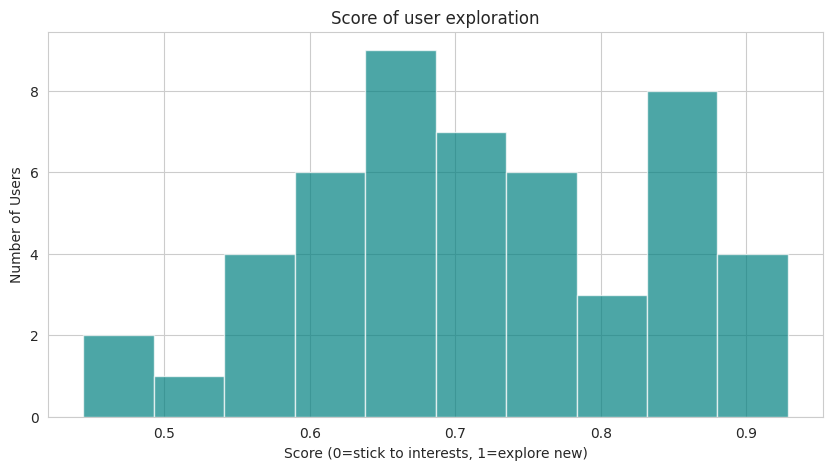

In [125]:
def calculate_exploration_score(user_id):
    user_engs = engagements_df[(engagements_df['user_id'] == user_id) & (engagements_df['engagement'] == 1)]['post_id']
    if len(user_engs) == 0:
        return 0.5

    user = users_df[users_df['user_id'] == user_id].iloc[0]
    user_interests = set(user['interests_list'])

    engaged_tags = []
    for post_id in user_engs:
        post = posts_df[posts_df['post_id'] == post_id]
        if len(post) > 0:
            engaged_tags.extend(post.iloc[0]['tags_list'])
    if not engaged_tags:
        return 0.5

    new_tags = [t for t in engaged_tags if t not in user_interests]

    return len(new_tags) / len(engaged_tags)

users_df['exploration_score'] = users_df['user_id'].apply(calculate_exploration_score)
users_df['segment'] = 'Medium'
users_df.loc[(users_df['exploration_score'] > 0.6) &
             (users_df['past_engagement_score'] > 0.6), 'segment'] = 'Power explorers'
users_df.loc[(users_df['exploration_score'] < 0.4) &
             (users_df['past_engagement_score'] > 0.6), 'segment'] = 'Loyal Fans'

print("Scores for User exploration")
print(f"   Average explorationoration: {users_df['exploration_score'].mean():.2f}")
plt.figure(figsize=(10, 5))
plt.hist(users_df['exploration_score'], bins=10, color='teal', alpha=0.7)
plt.title('Score of user exploration')
plt.xlabel('Score (0=stick to interests, 1=explore new)')
plt.ylabel('Number of Users')
plt.savefig('user_exploration.png', dpi=200)
plt.show()
plt.close()

## Model Testing

testing models
   1. Content-Based
   2. SVD 
   3. KNN 

   Comparison:
   Content-Based: 2.90 unique tags
   SVD: 4.10 unique tags
   KNN: 3.60 unique tags


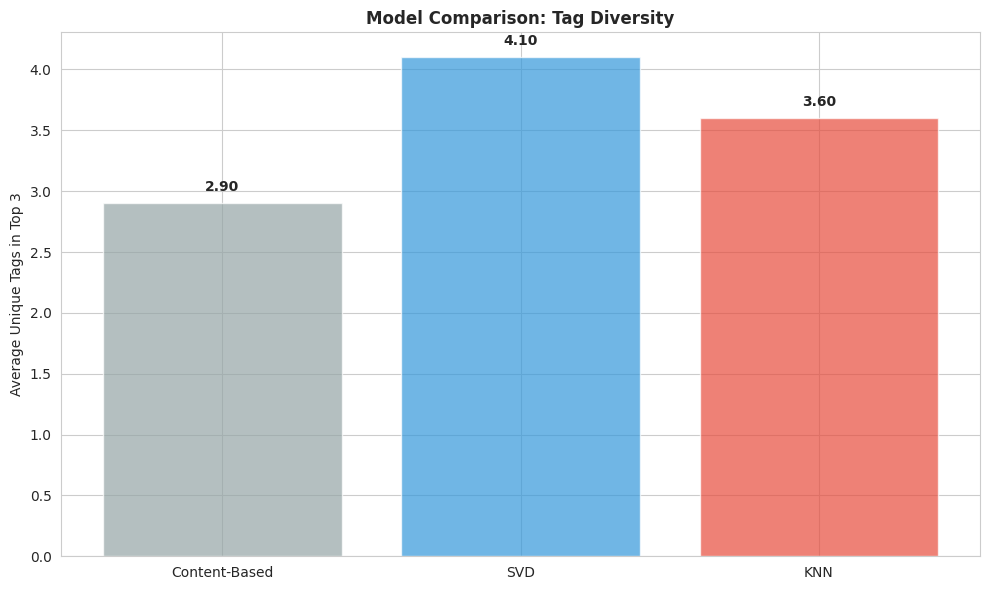

In [126]:
users_df['ints_text'] = users_df['interests_list'].apply(lambda x: ' '.join(x))
posts_df['tags_text'] = posts_df['tags_list'].apply(lambda x: ' '.join(x))

tfidf = TfidfVectorizer()
tfidf.fit(list(users_df['ints_text']) + list(posts_df['tags_text']))
user_tfidf = tfidf.transform(users_df['ints_text'])
post_tfidf = tfidf.transform(posts_df['tags_text'])

engagement_matrix = engagements_df.pivot_table(
    index='user_id', columns='post_id', values='engagement', fill_value=0
)

post_stats = engagements_df.groupby('post_id')['engagement'].agg(['sum', 'count']).reset_index()
post_stats.columns = ['post_id', 'total_eng', 'view_count']
post_stats['eng_rate'] = post_stats['total_eng'] / post_stats['view_count']
posts_df = posts_df.merge(post_stats, on='post_id', how='left').fillna(0)


print("testing models")

# MODEL 1:Content-Based
baseline_similarity = cosine_similarity(user_tfidf, post_tfidf)
print("   1. Content-Based")

# MODEL 2:SVD
from sklearn.decomposition import TruncatedSVD
user_post_matrix = engagement_matrix.fillna(0).values
n_components = min(10, min(user_post_matrix.shape) - 1)
svd = TruncatedSVD(n_components=n_components, random_state=42)
user_factors = svd.fit_transform(user_post_matrix)
item_factors = svd.components_.T
svd_predictions = user_factors @ item_factors.T
print(f"   2. SVD ")

# MODEL 3:KNN
from sklearn.neighbors import NearestNeighbors
knn = NearestNeighbors(n_neighbors=min(5, len(users_df)-1), metric='cosine')
knn.fit(user_post_matrix)
print(f"   3. KNN ")

def get_content_recs(user_id):
    idx = users_df[users_df['user_id'] == user_id].index[0]
    scores = baseline_similarity[idx]
    return [posts_df.iloc[i]['post_id'] for i in np.argsort(scores)[::-1][:10]]

def get_svd_recs(user_id):
    idx = users_df[users_df['user_id'] == user_id].index[0]
    scores = svd_predictions[idx]
    post_ids = engagement_matrix.columns
    return [post_ids[i] for i in np.argsort(scores)[::-1][:10] if i < len(post_ids)]

def get_knn_recs(user_id):
    idx = users_df[users_df['user_id'] == user_id].index[0]
    distances, indices = knn.kneighbors([user_post_matrix[idx]])
    avg_scores = user_post_matrix[indices[0][1:]].mean(axis=0)
    post_ids = engagement_matrix.columns
    return [post_ids[i] for i in np.argsort(avg_scores)[::-1][:10] if i < len(post_ids)]

def calc_diversity(rec_func, n_users=10):
    diversities = []
    for user_id in users_df['user_id'].head(n_users):
        recs = rec_func(user_id)[:3]
        tags = []
        for post_id in recs:
            post = posts_df[posts_df['post_id'] == post_id]
            if len(post) > 0:
                tags.extend(post.iloc[0]['tags_list'])
        diversities.append(len(set(tags)))
    return np.mean(diversities)

results = {
    'Content-Based': calc_diversity(get_content_recs),
    'SVD': calc_diversity(get_svd_recs),
    'KNN': calc_diversity(get_knn_recs)
}

print(f"\n   Comparison:")
for model, div in results.items():
    print(f"   {model}: {div:.2f} unique tags")

fig, ax = plt.subplots(figsize=(10, 6))
models = list(results.keys())
divs = list(results.values())
bars = ax.bar(models, divs, color=['#95a5a6', '#3498db', '#e74c3c'], alpha=0.7)
ax.set_title('Model Comparison: Tag Diversity', fontweight='bold')
ax.set_ylabel('Average Unique Tags in Top 3')
for i, v in enumerate(divs):
    ax.text(i, v + 0.1, f'{v:.2f}', ha='center', fontweight='bold')
plt.tight_layout()
plt.savefig('model_compr.png', dpi=200)
plt.show()
plt.close()


## Final Model

In [127]:
def get_recommendations(user_id, n=3):
    user_idx = users_df[users_df['user_id'] == user_id].index[0]
    user = users_df.iloc[user_idx]
    user_interests = set(user['interests_list'])  # CRITICAL: Get user's interests

    engaged_posts = set(engagements_df[(engagements_df['user_id'] == user_id) &
                                        (engagements_df['engagement'] == 1)]['post_id'])

    scores = []
    for post_idx, post in posts_df.iterrows():
        if post['post_id'] in engaged_posts:
            continue

        content_score = baseline_similarity[user_idx, post_idx]
        popularity_score = post['eng_rate']

        post_tags = set(post['tags_list'])
        new_tags = post_tags - user_interests
        discovery_score = len(new_tags) / len(post_tags) if len(post_tags) > 0 else 0

        final_score = (0.45 * content_score + 0.35 * popularity_score + 0.20 * discovery_score)

        scores.append({
            'post_id': post['post_id'],
            'final_score': final_score,
            'content_score': content_score,
            'popularity_score': popularity_score,
            'content_type': post['content_type'],
            'tags': post['tags']
        })

    scores.sort(key=lambda x: x['final_score'], reverse=True)
    return scores[:n]


all_recs = []
for user_id in users_df['user_id']:
    recs = get_recommendations(user_id, n=3)
    for rank, rec in enumerate(recs, 1):
        all_recs.append({
            'user_id': user_id,
            'rank': rank,
            'post_id': rec['post_id'],
            'final_score': rec['final_score'],
            'content_score': rec['content_score'],
            'popularity_score': rec['popularity_score'],
            'content_type': rec['content_type'],
            'tags': rec['tags']
        })

results_df = pd.DataFrame(all_recs)

print("Final model")
# Sample
print(f"\n   Sample for {users_df.iloc[0]['user_id']}:")
sample = results_df[results_df['user_id'] == users_df.iloc[0]['user_id']]
for _, row in sample.iterrows():
    print(f"   {row['rank']}. {row['post_id']} - {row['tags']} (score: {row['final_score']:.3f})")

Final model

   Sample for U1:
   1. P29 - sports, music (score: 0.600)
   2. P22 - sports, art (score: 0.583)
   3. P78 - sports, art (score: 0.564)


## Results

   Discovery Rate: 13.3%
   (recommendations outside user's stated interests)
   Catalog Coverage: 30.0%
   (30/100 posts recommended)

   Average Scores:
   Content: 0.555
   Popularity: 0.760
   Final: 0.579


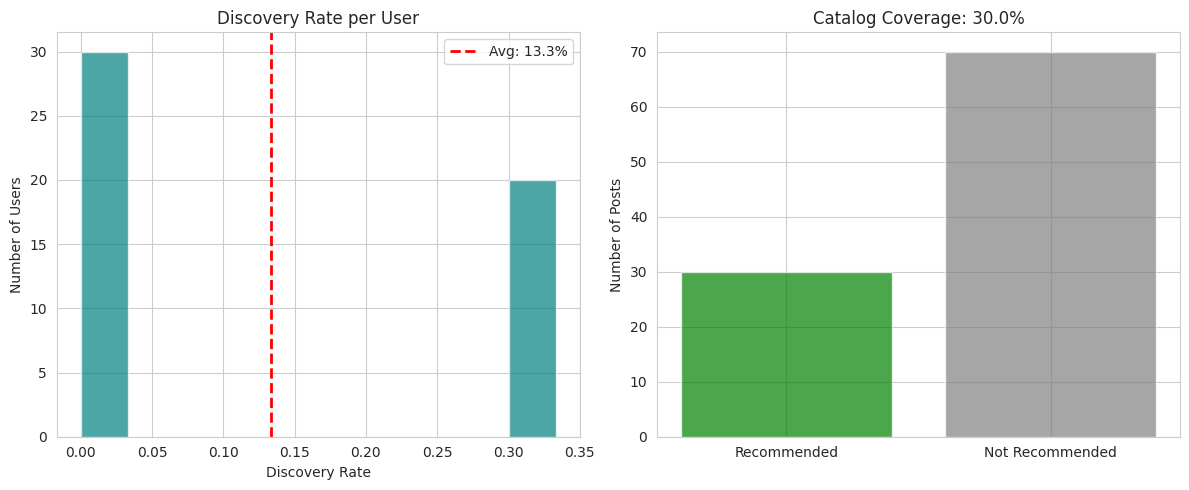

In [128]:
# M1: Discovery Rate
def calc_discovery_rate(user_id):
    user_interests = set(users_df[users_df['user_id'] == user_id].iloc[0]['interests_list'])
    user_recs = results_df[results_df['user_id'] == user_id]
    discovery_count = 0
    for _, rec in user_recs.iterrows():
        post_tags = set(posts_df[posts_df['post_id'] == rec['post_id']].iloc[0]['tags_list'])
        if not post_tags.intersection(user_interests):
            discovery_count += 1
    return discovery_count / len(user_recs) if len(user_recs) > 0 else 0
discovery_rates = [calc_discovery_rate(uid) for uid in users_df['user_id']]
avg_discovery = np.mean(discovery_rates)
print(f"   Discovery Rate: {avg_discovery:.1%}")
print(f"   (recommendations outside user's stated interests)")

# M2: Coverage
unique_posts = results_df['post_id'].nunique()
coverage = unique_posts / len(posts_df)
print(f"   Catalog Coverage: {coverage:.1%}")
print(f"   ({unique_posts}/{len(posts_df)} posts recommended)")

# M3: Score breakdown
print(f"\n   Average Scores:")
print(f"   Content: {results_df['content_score'].mean():.3f}")
print(f"   Popularity: {results_df['popularity_score'].mean():.3f}")
print(f"   Final: {results_df['final_score'].mean():.3f}")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].hist(discovery_rates, bins=10, color='teal', alpha=0.7)
axes[0].axvline(avg_discovery, color='red', linestyle='--', linewidth=2, label=f'Avg: {avg_discovery:.1%}')
axes[0].set_title('Discovery Rate per User')
axes[0].set_xlabel('Discovery Rate')
axes[0].set_ylabel('Number of Users')
axes[0].legend()

axes[1].bar(['Recommended', 'Not Recommended'],
            [unique_posts, len(posts_df) - unique_posts],
            color=['green', 'gray'], alpha=0.7)
axes[1].set_title(f'Catalog Coverage: {coverage:.1%}')
axes[1].set_ylabel('Number of Posts')

plt.tight_layout()
plt.savefig('eval_results.png', dpi=200)
plt.show()
plt.close()

results_df.to_csv('rec_output.csv', index=False)

## Summary

In [129]:
summary = {
    'Total Users': len(users_df),
    'Total Posts': len(posts_df),
    'Total Recommendations': len(results_df),
    'Discovery Rate': f"{avg_discovery:.1%}",
    'Catalog Coverage': f"{coverage:.1%}",
    'Avg Content Score': f"{results_df['content_score'].mean():.3f}",
    'Avg Popularity Score': f"{results_df['popularity_score'].mean():.3f}",
    'Avg Final Score': f"{results_df['final_score'].mean():.3f}"
}

print("Summary")
for key, val in summary.items():
    print(f"   {key}: {val}")

pd.DataFrame(list(summary.items()), columns=['Metric', 'Value']).to_csv(
    'summary_stats.csv', index=False
)

Summary
   Total Users: 50
   Total Posts: 100
   Total Recommendations: 150
   Discovery Rate: 13.3%
   Catalog Coverage: 30.0%
   Avg Content Score: 0.555
   Avg Popularity Score: 0.760
   Avg Final Score: 0.579
